In [77]:
import pandas as pd
import numpy as np
import torch
import sys
import timesead
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch
from timesead.models.reconstruction.lstm_ae import LSTMAE, LSTMAEAnomalyDetector
from timesead.models.reconstruction.tcn_ae import TCNAE, TCNAEAnomalyDetector
from timesead.models.reconstruction.usad import USADAnomalyDetector
from timesead.models.reconstruction.mscred import MSCREDAnomalyDetector
from timesead.models.prediction.gdn import GDN
from timesead.models.prediction.lstm_prediction import LSTMPrediction, LSTMPredictionAnomalyDetector
from timesead.models.prediction.tcn_prediction import TCNPredictionAnomalyDetector
from timesead.models.generative.omni_anomaly import OmniAnomaly
from timesead.models.generative.donut import Donut, DonutAnomalyDetector
from timesead.models.generative.madgan import MADGANAnomalyDetector
from timesead.models.generative.tadgan import TADGANAnomalyDetector
from timesead.models.generative.lstm_vae import VAEAnomalyDetectorSoelch, VAEAnomalyDetectorPark
from timesead.models.other.mtad_gat import MTAD_GATAnomalyDetector
from timesead.models.reconstruction.stgat import STGAT
from timesead.models.other.ncad import NCADAnomalyDetector
from timesead.models.other.thoc import THOCAnomalyDetector
from timesead.models.reconstruction.anom_trans import AnomalyTransformer
from timesead.models.reconstruction.genad import GENADDetector
from timesead.models.baselines.iforest import IForestAD
from timesead.models.baselines.kmeans import KMeansAD
from timesead.models.baselines.knn import KNNAD
from timesead.models.baselines.pcas import PCAAnomalyDetector

In [41]:
def read_with_date_index(file_path, date_col='date'):
    df = pd.read_csv(file_path)
    
    # Vérifier si la colonne de dates est présente dans le DataFrame
    if date_col in df.columns:
        # Convertir la colonne de dates en datetime
        df[date_col] = pd.to_datetime(df[date_col])
        # Définir la colonne de dates comme index
        df.set_index(date_col, inplace=True)

        if df.index.dtype != "datetime64[ns]":
            raise ValueError("L'index du DataFrame n'est pas au format datetime64[ns].")
            
        if not df.index.is_monotonic_increasing:
            print("L'index n'est pas trié. Tri en cours...")
            df.sort_index(inplace=True)
    else:
        print(f"La colonne '{date_col}' n'a pas été trouvée. L'index par défaut sera utilisé.")
    
    return df

In [ ]:
file_path = "C:/Users/pellerinc/Downloads/occupancy+detection/datatest2.txt"
df1 = read_csv_with_date_index(file_path)

In [42]:
print(df1.index.dtype)  # Doit être "datetime64[ns]"

datetime64[ns]


In [43]:
print(df1.index.is_monotonic_increasing)  # Doit renvoyer True si l'index est bien trié

True


In [33]:
print(df1.index.to_series().diff().value_counts())  # Vérifier l'espacement des timestamps

date
0 days 00:01:00    5849
0 days 00:00:59    1951
0 days 00:01:01    1951
Name: count, dtype: int64


In [16]:
df1.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [ ]:
df1.shape

In [ ]:
df1.info()

In [59]:
df1.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000
mean,21.001768,29.891910,123.067930,753.224832,0.004589,0.210111
std,1.020693,3.952844,208.221275,297.096114,0.000531,0.407408
min,19.500000,21.865000,0.000000,484.666667,0.003275,0.000000
25%,20.290000,26.642083,0.000000,542.312500,0.004196,0.000000
50%,20.790000,30.200000,0.000000,639.000000,0.004593,0.000000
75%,21.533333,32.700000,208.250000,831.125000,0.004998,0.000000
max,24.390000,39.500000,1581.000000,2076.500000,0.005769,1.000000


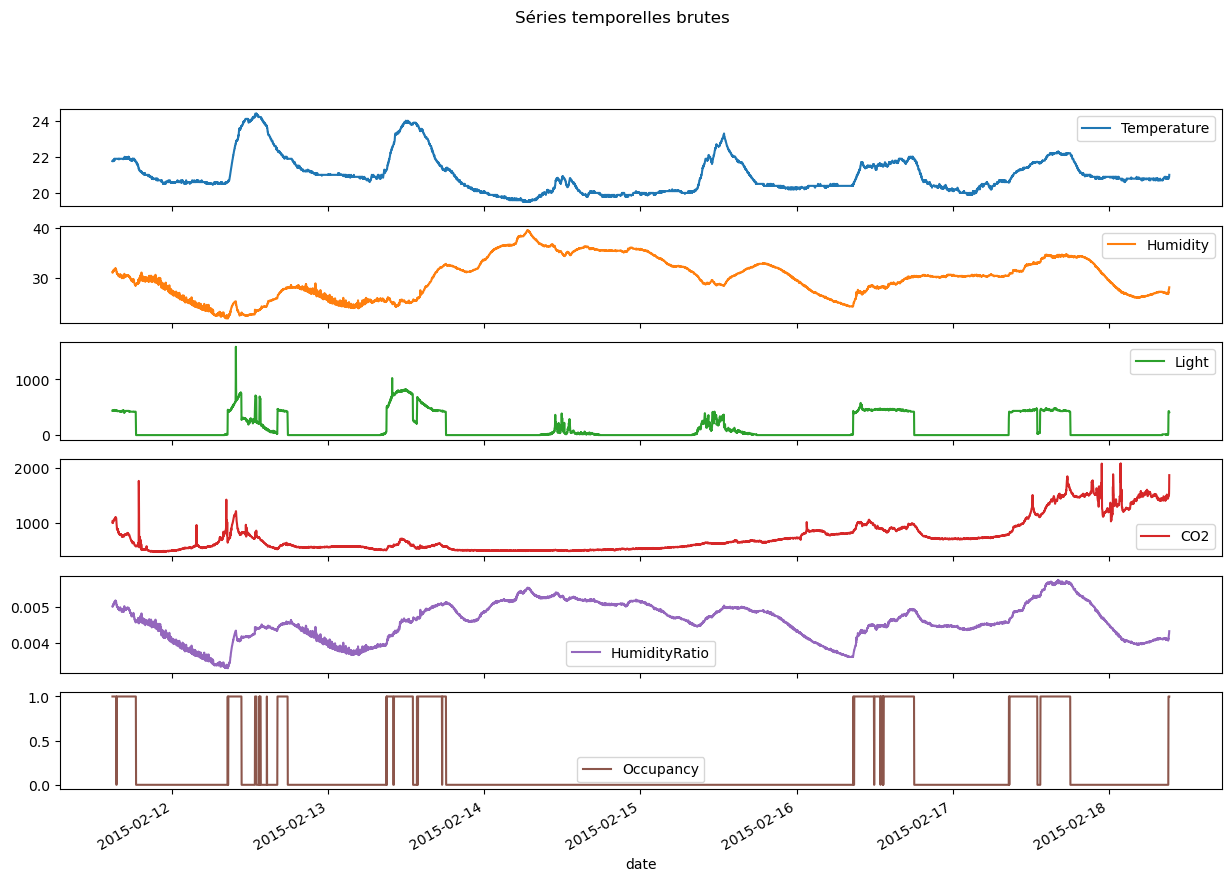

In [45]:
df1.plot(subplots=True, figsize=(15, 10), title="Séries temporelles brutes")
plt.show()

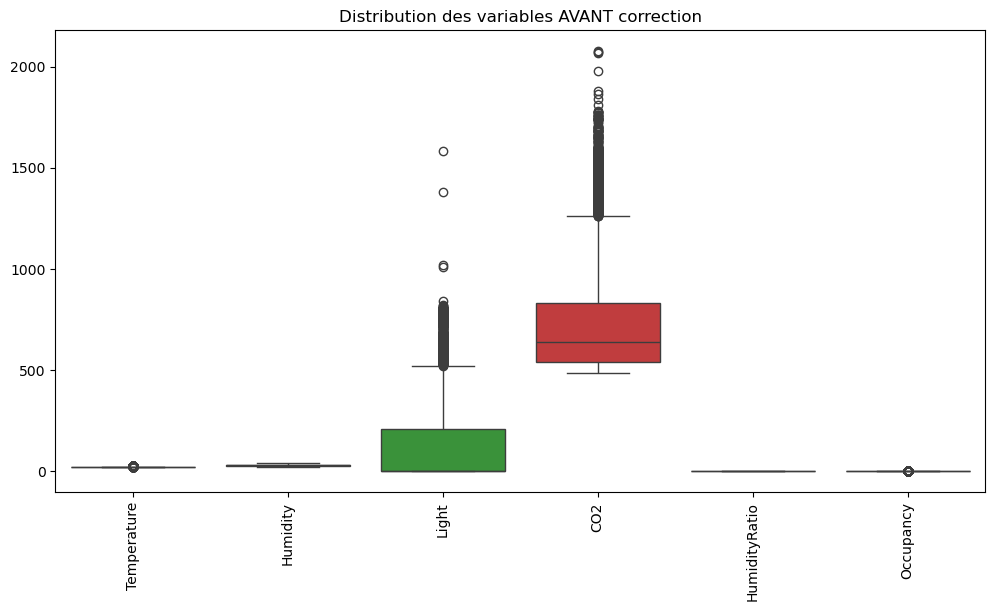

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df1)
plt.xticks(rotation=90)
plt.title("Distribution des variables AVANT correction")
plt.show()

In [69]:
class UpstreamDataPreparation:
    def __init__(self, method="IQR", threshold=1.5, sensor_threshold=3, seq_length=50, scale_method="standard"):
        self.method = method
        self.threshold = threshold
        self.sensor_threshold = sensor_threshold
        self.seq_length = seq_length
        self.scale_method = scale_method
        self.scaler = None  # Scaler stocké pour réutilisation

    def detect_outliers(self, data):
        """Détecte les outliers avec IQR ou MAD."""
        if self.method == "IQR":
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            return (data < (Q1 - self.threshold * IQR)) | (data > (Q3 + self.threshold * IQR))
        elif self.method == "MAD":
            median = data.median()
            mad = (data - median).abs().median()
            return (data - median).abs() > (self.threshold * 1.4826 * mad)

    def classify_outliers(self, data, outlier_mask):
        """Classe les outliers en anomalies moteur ou erreurs capteurs."""
        data_clean = data.copy()
        anomalies_moteur = outlier_mask.sum(axis=1) >= self.sensor_threshold
        for col in data.columns:
            mask = outlier_mask[col] & ~anomalies_moteur
            data_clean.loc[mask, col] = np.nan  # Suppression des erreurs capteurs
        data_clean = data_clean.interpolate(method='time').bfill()
        return data_clean, anomalies_moteur

    def normalize_data(self, train_data, test_data=None):
        """Normalisation des données avec choix entre MinMaxScaler et StandardScaler."""
        if self.scale_method == "minmax":
            self.scaler = MinMaxScaler()
        else:
            self.scaler = StandardScaler()
        
        train_data_scaled = pd.DataFrame(self.scaler.fit_transform(train_data), 
                                         columns=train_data.columns, index=train_data.index)
        
        if test_data is not None:
            test_data_scaled = pd.DataFrame(self.scaler.transform(test_data), 
                                            columns=test_data.columns, index=test_data.index)
            return train_data_scaled, test_data_scaled
        
        return train_data_scaled
    
    def denormalize_data(self, normalized_data):
        """Dénormalise les données à leur échelle originale."""
        if self.scaler is None:
            raise ValueError("Le scaler n'a pas encore été défini. Normalise d'abord les données.")
        
        return pd.DataFrame(self.scaler.inverse_transform(normalized_data), 
                            columns=normalized_data.columns, index=normalized_data.index)

    def create_sequences(self, data):
        """Transforme les données en séquences temporelles adaptées à TimeSeAD."""

        data_np = data.to_numpy()

        # Vérifier que les données sont suffisantes pour créer des séquences
        if len(data_np) < self.seq_length:
            raise ValueError(f"Pas assez de données ({len(data_np)}) pour créer des séquences de longueur {self.seq_length}")

        # Générer les séquences sous forme d'un unique tableau NumPy
        sequences = np.array([data_np[i:i + self.seq_length] for i in range(len(data_np) - self.seq_length)])

        # Conversion efficace en tenseur PyTorch
        return torch.tensor(sequences, dtype=torch.float32)

    def preprocess_data(self, data):
        """Prépare les données : vérification, interpolation, correction des outliers."""
        if not isinstance(data.index, pd.DatetimeIndex):
            raise ValueError("L'index du DataFrame doit être de type DateTime.")

        data.sort_index(inplace=True)
        print("Fréquence des timestamps :")
        print(data.index.to_series().diff().value_counts())

        data = data.resample("1min").mean()
        data = data.interpolate(method='time').bfill()

        print("Détection et correction des outliers...")
        outlier_mask = self.detect_outliers(data)
        data_clean, anomalies_moteur = self.classify_outliers(data, outlier_mask)

        # Affichage des anomalies détectées
        print("Nombre total d'anomalies détectées :", anomalies_moteur.sum().sum())
        print("Aperçu des anomalies détectées :")
        print(anomalies_moteur[anomalies_moteur])


        return data_clean, anomalies_moteur

    def process(self, data, train_size=0.8):
        """Pipeline complet : prétraitement, normalisation, conversion en séquences temporelles."""
        data_clean, anomalies_moteur = self.preprocess_data(data)

        print("Normalisation des données...")
        train_data = data_clean.iloc[:int(len(data_clean) * train_size)]
        test_data = data_clean.iloc[int(len(data_clean) * train_size):]
        train_data, test_data = self.normalize_data(train_data, test_data)

        X_train_tensor = self.create_sequences(train_data)
        X_test_tensor = self.create_sequences(test_data)

        torch.save(X_train_tensor, "X_train_tensor.pt")
        torch.save(X_test_tensor, "X_test_tensor.pt")
        print("Tenseurs sauvegardés.")

        return X_train_tensor, X_test_tensor, anomalies_moteur


In [68]:
detector = UpstreamDataPreparation(method="IQR", threshold=1.5, sensor_threshold=3, seq_length=50, scale_method="standard")

df_new = detector.preprocess_data(df1)

# Exécuter le pipeline complet
X_train_tensor, X_test_tensor, anomalies_moteur = detector.process(df1)

print(f"Tenseur entraînement : {X_train_tensor.shape}")
print(f"Tenseur test : {X_test_tensor.shape}")

Fréquence des timestamps :
date
0 days 00:01:00    5849
0 days 00:00:59    1951
0 days 00:01:01    1951
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées : 215
Aperçu des anomalies détectées :
date
2015-02-12 10:15:00    True
2015-02-12 10:16:00    True
2015-02-12 10:17:00    True
2015-02-12 10:18:00    True
2015-02-12 10:19:00    True
                       ... 
2015-02-13 14:26:00    True
2015-02-13 14:27:00    True
2015-02-13 14:28:00    True
2015-02-13 14:29:00    True
2015-02-13 14:30:00    True
Length: 215, dtype: bool
Fréquence des timestamps :
date
0 days 00:01:00    5849
0 days 00:00:59    1951
0 days 00:01:01    1951
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées : 215
Aperçu des anomalies détectées :
date
2015-02-12 10:15:00    True
2015-02-12 10:16:00    True
2015-02-12 10:17:00    True
2015-02-12 10:18:00    True
2015-02-12 10:19:00    True
                       ... 
2